# 🔍 Dynamic Programming in a GridWorld – A Step-by-Step Tutorial

In this notebook, we'll explore how to model a simple 2D environment (called GridWorld) and solve it using the **Value Iteration** and **Policy Iteration** algorithms from Reinforcement Learning.

We'll cover:
- The environment layout (goals, traps, walls)
- The reward function and transition probabilities
- A random policy baseline
- Value Iteration implementation
- Visualization of the learned optimal policy

---

## 🌍 The GridWorld Environment

We define a simple 2D grid-based world where an agent (like a robot or Pac-Man) can move in four directions: **up, right, down, and left**.

Each cell in the grid can be one of the following:

- `0`: A normal cell. The agent can move into it and receives a small negative reward (e.g., -0.04) to encourage shorter paths.
- `1`: The goal. Reaching this cell ends the episode with a positive reward (e.g., +1).
- `2`: A poison cell. Entering this cell ends the episode with a penalty (e.g., -1).
- `3`: A wall. The agent cannot pass through this cell.

We define the environment using a grid map and create a class `GridWorld` to encapsulate the logic for:
- Computing state indices from grid positions
- Generating a reward function
- Creating a stochastic transition model where the agent might slip left or right of its intended direction
- Visualizing the grid and policy arrows


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class GridWorld:
    """
    A class to model a GridWorld environment.

    Grid codes:
    0 → normal state (step cost -0.04)
    1 → goal state (reward +1)
    2 → poison/death (reward -1)
    3 → wall (not passable)
    """
    def __init__(self, grid_map, rewards=None):
        if rewards is None:
            rewards = {
                0: -0.04,  # Normal cell step penalty
                1: 1.0,    # Goal
                2: -1.0,   # Poison
                3: 0.0     # Wall
            }

        self.map = np.array(grid_map)
        self.num_rows, self.num_cols = self.map.shape
        self.num_states = self.num_rows * self.num_cols
        self.num_actions = 4  # up, right, down, left
        self.rewards = rewards

        self.reward_function = self.get_reward_function()
        self.transition_model = self.get_transition_model()

    def get_state(self, row, col):
        return row * self.num_cols + col

    def get_position(self, state):
        return divmod(state, self.num_cols)

    def get_reward_function(self):
        reward_table = np.zeros(self.num_states)
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state(r, c)
                reward_table[s] = self.rewards[self.map[r, c]]
        return reward_table

    def get_transition_model(self, slip=0.2):
        T = np.zeros((self.num_states, self.num_actions, self.num_states))
        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state(r, c)
                if self.map[r, c] == 3:
                    T[s, :, s] = 1.0
                    continue
                for a in range(self.num_actions):
                    transitions = self.get_transitions(r, c, a, slip)
                    for s_prime, p in transitions.items():
                        T[s, a, s_prime] = p
        return T

    def get_transitions(self, r, c, a, slip=0.2):
        directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        probs = [1 - slip, slip / 2, slip / 2]

        results = {}
        for i, offset in enumerate([0, 1, -1]):
            new_a = (a + offset) % 4
            dr, dc = directions[new_a]
            new_r, new_c = r + dr, c + dc
            if 0 <= new_r < self.num_rows and 0 <= new_c < self.num_cols:
                if self.map[new_r, new_c] != 3:
                    s_prime = self.get_state(new_r, new_c)
                else:
                    s_prime = self.get_state(r, c)
            else:
                s_prime = self.get_state(r, c)
            results[s_prime] = results.get(s_prime, 0) + probs[i]
        return results

    def display_map(self):
        fig, ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}

        for r in range(self.num_rows):
            for c in range(self.num_cols):
                cell_type = self.map[r, c]
                rect = patches.Rectangle((c, self.num_rows - r - 1), 1, 1,
                                         facecolor=cmap[cell_type], edgecolor='gray')
                ax.add_patch(rect)

        ax.set_xlim(0, self.num_cols)
        ax.set_ylim(0, self.num_rows)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("GridWorld Layout")
        plt.show()

    def visualize_policy_and_values(self, policy=None, values=None, title=""):
        fig, ax = plt.subplots(figsize=(self.num_cols, self.num_rows))
        cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}
        arrow_map = ['↑', '→', '↓', '←']

        for r in range(self.num_rows):
            for c in range(self.num_cols):
                s = self.get_state(r, c)
                cell_type = self.map[r, c]
                color = cmap[cell_type]

                rect = patches.Rectangle((c, self.num_rows - r - 1), 1, 1,
                                         facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

                if cell_type != 3:
                    ax.text(c + 0.5, self.num_rows - r - 0.2,
                            f"s = {s}", ha='center', fontsize=8, color='gray')

                if cell_type in [1, 2, 3]:
                    continue

                if values is not None:
                    ax.text(c + 0.5, self.num_rows - r - 0.85,
                            f"v = {values[s]:.2f}", ha='center', fontsize=10)

                if policy is not None and policy[s] != -1:
                    center_x = c + 0.5
                    center_y = self.num_rows - r - 0.5
                    direction = policy[s]
                    if direction == 0:  # up
                        triangle = [[center_x, center_y + 0.25],
                                    [center_x - 0.2, center_y - 0.2],
                                    [center_x + 0.2, center_y - 0.2]]
                    elif direction == 1:  # right
                        triangle = [[center_x + 0.25, center_y],
                                    [center_x - 0.2, center_y + 0.2],
                                    [center_x - 0.2, center_y - 0.2]]
                    elif direction == 2:  # down
                        triangle = [[center_x, center_y - 0.25],
                                    [center_x - 0.2, center_y + 0.2],
                                    [center_x + 0.2, center_y + 0.2]]
                    elif direction == 3:  # left
                        triangle = [[center_x - 0.25, center_y],
                                    [center_x + 0.2, center_y + 0.2],
                                    [center_x + 0.2, center_y - 0.2]]

                    arrow = patches.Polygon(triangle, closed=True, color='#08519c', alpha=0.8)
                    ax.add_patch(arrow)

        ax.set_xlim(0, self.num_cols)
        ax.set_ylim(0, self.num_rows)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=14)
        plt.show()



---

## 🗺️ Visualizing the Grid World

Now that we’ve defined the environment, let’s visualize the grid layout. This helps us clearly see the positions of:

- ✅ Goal cells (green)
- ❌ Poison cells (red)
- ⬛ Wall cells (black)
- ⬜ Normal walkable cells (white)

We’ll define a small 4×3 map for this experiment.
---

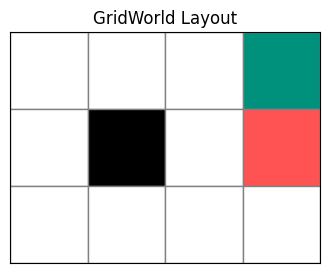

In [ ]:
# Define a 3x4 grid map layout:
# 0 = normal cell, 1 = goal, 2 = poison, 3 = wall

grid_map = [
    [0, 0, 0, 1],
    [0, 3, 0, 2],
    [0, 0, 0, 0]
]

# Initialize the GridWorld environment
env = GridWorld(grid_map)

# Show the grid with color-coded cells
env.display_map()


---

## 🔍 Inspecting the Grid World Internals

Now that we’ve visualized the layout of the environment, let’s take a deeper look into what’s happening behind each grid cell:

- **Reward Function**: Each cell has an associated reward that the agent receives upon entering it.
- **Transition Probabilities**: In a stochastic environment, even if the agent intends to move in a certain direction, it may end up in a different neighboring cell.

This deeper inspection will help us understand how the agent perceives and interacts with the environment before we apply any learning algorithm.




### 🔢 2.1 State Numbering in GridWorld

Before we visualize rewards or value functions, it's helpful to understand how the GridWorld environment is numbered.

Each cell in the grid represents a unique **state**, and states are numbered in **row-major order** (left-to-right, top-to-bottom). The layout below shows the mapping from each `(row, col)` position to its corresponding state number.

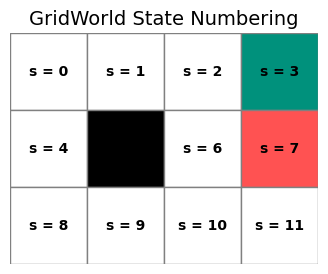

In [ ]:
def show_state_numbering(env):
    """
    Display GridWorld with 's = #' labels for each state.
    """
    fig, ax = plt.subplots(figsize=(env.num_cols, env.num_rows))
    cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}

    for r in range(env.num_rows):
        for c in range(env.num_cols):
            s = env.get_state(r, c)
            cell_type = env.map[r, c]
            color = cmap[cell_type]

            rect = patches.Rectangle((c, env.num_rows - r - 1), 1, 1, facecolor=color, edgecolor='gray')
            ax.add_patch(rect)

            if cell_type != 3:
                ax.text(c + 0.5, env.num_rows - r - 0.5,
                        f"s = {s}", ha='center', va='center', fontsize=10, weight='bold')

    ax.set_xlim(0, env.num_cols)
    ax.set_ylim(0, env.num_rows)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title("GridWorld State Numbering", fontsize=14)
    plt.show()


show_state_numbering(env)


---


### 🎯 2.2 Rewards per State

Every cell in our GridWorld is associated with a numerical reward:

- `+1` for reaching the goal
- `–1` for stepping into a poison cell
- `–0.04` for each move through a normal cell (to encourage shorter paths)
- `0` for wall cells (which are impassable and don't change state)

Let’s plot these rewards directly onto the grid to make the incentive structure of the environment clear.


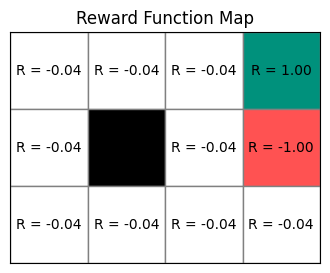

In [ ]:
def display_reward_map(env):
    """
    Visualizes the reward values for each state in the grid.
    """
    fig, ax = plt.subplots(figsize=(env.num_cols, env.num_rows))
    cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}

    for r in range(env.num_rows):
        for c in range(env.num_cols):
            cell_type = env.map[r, c]
            state = env.get_state(r, c)

            # Draw the cell
            rect = patches.Rectangle((c, env.num_rows - r - 1), 1, 1,
                                     facecolor=cmap[cell_type], edgecolor='gray')
            ax.add_patch(rect)

            # Write the reward
            reward = env.reward_function[state]
            if cell_type != 3:  # don't show text in wall
                ax.text(c + 0.5, env.num_rows - r - 0.5,
                        f"R = {reward:.2f}", ha='center', va='center', fontsize=10)

    ax.set_xlim(0, env.num_cols)
    ax.set_ylim(0, env.num_rows)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Reward Function Map")
    plt.show()

# Call the function to display rewards
display_reward_map(env)


### 🔁 2.3 Transition Probabilities

Our environment is **stochastic**, meaning that even if the agent tries to move in one direction (e.g., UP), it might slip and move to the LEFT or RIGHT instead with a small probability.

By default, we use:
- **0.8** probability to go in the intended direction
- **0.1** probability to slip left
- **0.1** probability to slip right

Let’s visualize the transition probabilities for a **specific action (e.g., UP)** from **each state**. For each grid cell, we'll:
- Show arrows indicating where the agent might end up
- Annotate them with corresponding transition probabilities


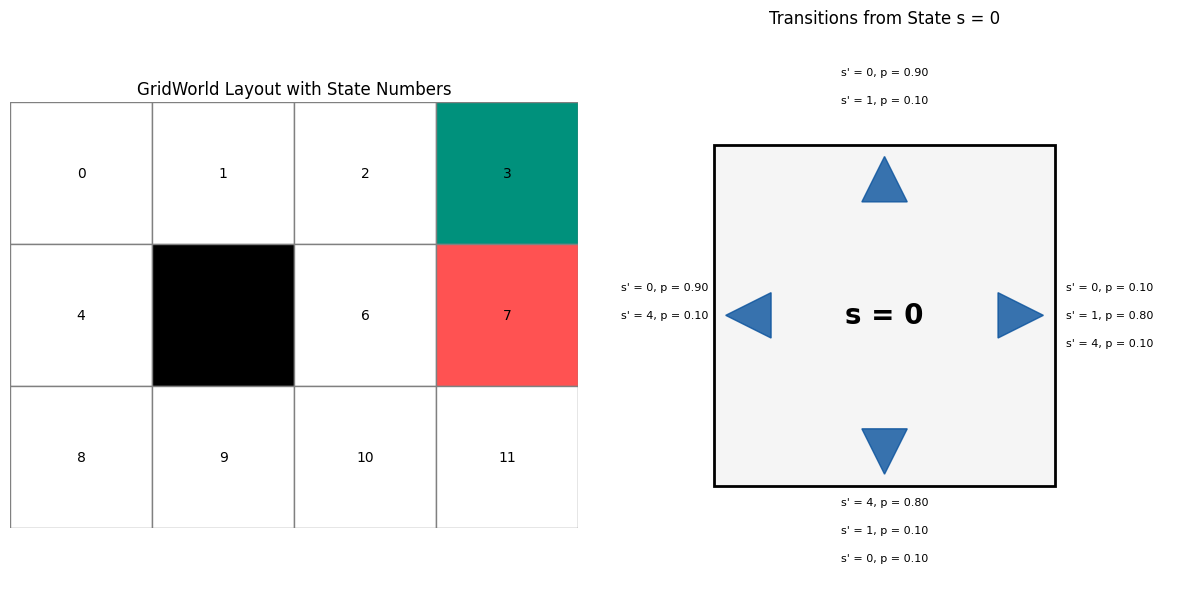

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_state_with_distribution(env, state):
    """
    Shows the full GridWorld layout with state numbers (left),
    and the transition distribution from a selected state (right).
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # -----------------------------
    # LEFT: GridWorld Layout
    # -----------------------------
    cmap = {0: 'white', 1: '#00917C', 2: '#FF5252', 3: 'black'}  # normal, goal, poison, wall

    for r in range(env.num_rows):
        for c in range(env.num_cols):
            s = env.get_state(r, c)
            cell_type = env.map[r, c]
            color = cmap[cell_type]

            rect = patches.Rectangle((c, env.num_rows - r - 1), 1, 1, facecolor=color, edgecolor='gray')
            ax1.add_patch(rect)

            if cell_type != 3:
                ax1.text(c + 0.5, env.num_rows - r - 0.5, f"{s}", ha='center', va='center', fontsize=10)

    ax1.set_xlim(0, env.num_cols)
    ax1.set_ylim(0, env.num_rows)
    ax1.set_aspect('equal')
    ax1.axis('off')
    ax1.set_title("GridWorld Layout with State Numbers", fontsize=12)

    # -----------------------------
    # RIGHT: Transition Distribution from selected state
    # -----------------------------
    ax = ax2

    # Draw the central grid square
    rect = patches.Rectangle((1, 1), 3, 3, facecolor='whitesmoke', edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(2.5, 2.5, f"s = {state}", ha='center', va='center', fontsize=20, weight='bold')

    # Triangle arrow definitions and label positions
    triangle_defs = {
        0: ([ [2.5, 3.9], [2.3, 3.5], [2.7, 3.5] ], (2.5, 4.6), 'UP'),
        1: ([ [3.9, 2.5], [3.5, 2.7], [3.5, 2.3] ], (4.1, 2.5), 'RIGHT'),
        2: ([ [2.5, 1.1], [2.3, 1.5], [2.7, 1.5] ], (2.5, 0.4), 'DOWN'),
        3: ([ [1.1, 2.5], [1.5, 2.7], [1.5, 2.3] ], (0.95, 2.5), 'LEFT'),
    }

    for action, (triangle_pts, text_anchor, _) in triangle_defs.items():
        triangle = patches.Polygon(triangle_pts, closed=True, color='#08519c', alpha=0.8)
        ax.add_patch(triangle)

        probs = env.transition_model[state, action]
        transitions = [(s_prime, p) for s_prime, p in enumerate(probs) if p > 0]

        for i, (s_prime, p) in enumerate(transitions):
            if action == 0:  # UP
                x = text_anchor[0]
                y = text_anchor[1] - i * 0.25
                ha, va = 'center', 'bottom'
            elif action == 1:  # RIGHT
                x = text_anchor[0]
                y = text_anchor[1] + 0.25 - i * 0.25
                ha, va = 'left', 'center'
            elif action == 2:  # DOWN
                x = text_anchor[0]
                y = text_anchor[1] + i * 0.25
                ha, va = 'center', 'top'
            elif action == 3:  # LEFT
                x = text_anchor[0]
                y = text_anchor[1] + 0.25 - i * 0.25
                ha, va = 'right', 'center'

            ax.text(x, y, f"s' = {s_prime}, p = {p:.2f}", fontsize=8, ha=ha, va=va, color='black')

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"Transitions from State s = {state}", fontsize=12)

    plt.tight_layout()
    plt.show()


# Example usage:
draw_state_with_distribution(env, state=0)







---

---

## 🎲 Running a Random Policy in GridWorld

Before we compute an optimal policy, let’s try executing a random policy.

A random policy chooses an action uniformly at random in every state. This helps establish a baseline behavior — often inefficient, looping, or getting stuck — that we can later compare against a learned policy from value iteration.


In [ ]:
def generate_random_policy(env):
    """
    Returns a random policy: one action (0–3) per state.
    Walls are set to -1 to indicate no action.
    """
    policy = np.random.randint(0, env.num_actions, size=env.num_states)

    for r in range(env.num_rows):
        for c in range(env.num_cols):
            if env.map[r, c] == 3:  # wall
                s = env.get_state(r, c)
                policy[s] = -1  # no action for walls
    return policy

In [ ]:
# Generate a random policy
random_policy = generate_random_policy(env)

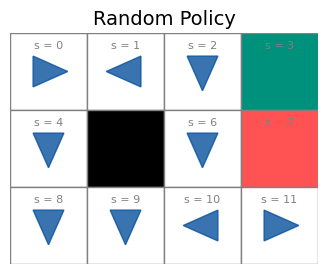

In [ ]:
# Visualize the random policy
env.visualize_policy_and_values(policy=random_policy, values=None, title="Random Policy")

---

## 🧠 Solving GridWorld using Value Iteration

- Value Iteration is a dynamic programming technique that finds the optimal value function by repeatedly applying the Bellman Optimality Equation.

- Once the value function converges, the optimal policy is derived by selecting the action that maximizes the expected return at each state.

### 🔁 Bellman Optimality Equation:

$$
V^*(s) = \max_a \sum_{s'} P(s' \mid s, a) \left[ R(s, a, s') + \gamma \cdot V^*(s') \right]
$$

Where:
- \( s \) is the current state
- \( a \) is an action
- \( s' \) is the next state
- \( P(s' \mid s, a) \) is the transition probability
- \( R(s, a, s') \) is the reward received after transitioning
- \( \gamma \in [0, 1] \) is the discount factor



We apply this update iteratively until the values converge (i.e., changes become negligible), and then derive the optimal policy by choosing the best action in each state.

In the next step, we will implement this algorithm.


In [ ]:
class ValueIteration:
    """
    Performs Value Iteration to solve an MDP defined by a GridWorld environment.
    Computes the optimal value function and extracts the optimal policy.
    """

    def __init__(self, env, gamma=0.9):
        """
        Initialize the Value Iteration algorithm.

        Args:
            env: an instance of GridWorld
            gamma: discount factor for future rewards (0 ≤ γ ≤ 1)
        """
        self.env = env
        self.gamma = gamma

        self.num_states = env.num_states
        self.num_actions = env.num_actions
        self.T = env.transition_model         # shape: (S, A, S')
        self.R = env.reward_function          # shape: (S,)
        self.V = np.zeros(self.num_states)    # Initialize value table V(s) = 0
        self.policy = np.full(self.num_states, -1, dtype=int)  # Initialize policy π(s) = -1

    def run(self, threshold=1e-4, max_iterations=1000):
        """
        Run the Value Iteration algorithm until the value function converges.

        Args:
            threshold: stop when max value change (delta) < threshold
            max_iterations: safety cap to prevent infinite loops
        """
        for iteration in range(max_iterations):
            delta = 0
            new_V = np.copy(self.V)  # To store updated values

            for s in range(self.num_states):
                row, col = self.env.get_position(s)

                # Skip terminal or wall states
                if self.env.map[row, col] in [1, 2, 3]:
                    self.V[s] = self.R[s]  # clamp to fixed reward
                    continue

                q_values = []

                # Compute expected value for each action
                for a in range(self.num_actions):
                    q = 0

                    transitions = self.env.get_transitions(row, col, a, slip = 0.2)  # return {s': prob}
                    for s_prime, prob in transitions.items():
                        reward = self.R[s_prime]
                        q += prob * (reward + self.gamma * self.V[s_prime])

                    q_values.append(q)

                # Update the state's value with the best Q(s,a)
                new_V[s] = max(q_values)

                # Track max value change for convergence check
                delta = max(delta, abs(new_V[s] - self.V[s]))

            self.V = new_V

            if delta < threshold:
                print(f"✅ Converged after {iteration + 1} iterations.")
                break
        else:
            print("⚠️ Reached max iterations without full convergence.")

        # Extract final policy from converged value function
        self.extract_policy()

    def extract_policy(self):
        """
        After convergence, extract the optimal policy by choosing the best action
        for each state based on the computed value function.
        """
        for s in range(self.num_states):
            row, col = self.env.get_position(s)

            if self.env.map[row, col] == 3:
                self.policy[s] = -1  # No policy for wall states
                continue

            best_action = -1
            best_value = -np.inf

            # Find action with highest expected value
            for a in range(self.num_actions):
                q = 0
                for s_prime, prob in enumerate(self.T[s, a]):
                    if prob > 0:
                        reward = self.R[s_prime]
                        q += prob * (reward + self.gamma * self.V[s_prime])

                if q > best_value:
                    best_value = q
                    best_action = a

            self.policy[s] = best_action


In [ ]:
# Grid map: 0 = normal, 1 = goal, 2 = poison, 3 = wall
grid_map = [
    [0, 0, 0, 1],
    [0, 3, 0, 2],
    [0, 0, 0, 0]
]

# Build world and solve Value Iteration
world = GridWorld(grid_map)
vi = ValueIteration(world, gamma=0.9)
vi.run()

# View results:
print("State Values:", vi.V)
print("Optimal Policy:", vi.policy)

✅ Converged after 16 iterations.
State Values: [0.61045798 0.76620698 0.92818025 0.         0.48722241 0.
 0.58493378 0.         0.37290884 0.31740618 0.41706092 0.08162179]
Optimal Policy: [ 1  1  1  0  0 -1  0  0  0  1  0  3]


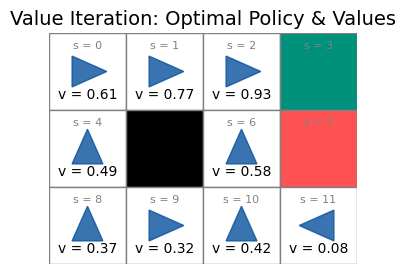

In [ ]:
# Visualize optimal value and policy
world.visualize_policy_and_values(policy=vi.policy, values=vi.V, title="Value Iteration: Optimal Policy & Values")

line.png

## 🔍 Policy Iteration in a GridWorld

In the previous section, we explored Value Iteration, where we iteratively updated state values using the Bellman optimality equation and derived the optimal policy at the end.

Now, we shift to another dynamic programming approach called Policy Iteration.


---


### 🎯 What is Policy Iteration?

Policy Iteration is an algorithm used to compute the **optimal policy** in a Markov Decision Process (MDP). It alternates between:

1. **Policy Evaluation**  
   Given a fixed policy \( \pi \), we compute the value function \( V^\pi(s) \) — the expected return from each state when following the current policy.

2. **Policy Improvement**  
   Using the updated value function, we find better actions at each state by computing \( Q(s, a) \) and updating the policy greedily:

   \[
   \pi(s) = \arg\max_a \sum_{s'} P(s' \mid s, a) \left[ R(s') + \gamma V^\pi(s') \right]
   \]

We repeat these two steps until the policy becomes stable — i.e., **no further improvements are possible**.

---

### 🔍 Why Use Policy Iteration?

- ✅ **Fast convergence**: It often converges in fewer iterations than value iteration.
- ✅ **Explicit policy control**: You always maintain a current working policy.
- ✅ **Interpretable improvement**: You can monitor how decisions change between iterations.

---

### 🧠 Key Intuition

- In **policy evaluation**, we don’t aim for optimality — we’re just measuring how good the current policy is.
- In **policy improvement**, we challenge the policy at every state using the current value estimates.
- Even if the current policy doesn’t explore the entire state space, **we still compute value estimates for all states**, allowing us to discover better strategies through expected rewards.

---

Next, we’ll implement the Policy Iteration algorithm on our GridWorld environment and visualize the resulting optimal policy. 👇

In [ ]:
class PolicyIteration:
    """
    A clear implementation of Policy Iteration for MDPs.
    """

    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.num_states = env.num_states
        self.num_actions = env.num_actions
        self.T = env.transition_model
        self.R = env.reward_function
        self.V = np.zeros(self.num_states)  # Initialize value function
        self.policy = self._init_policy()

    def _init_policy(self):
        """
        Initialize a random policy, with -1 for terminal or wall states.
        """
        policy = np.random.randint(0, self.num_actions, size=self.num_states)
        for s in range(self.num_states):
            r, c = self.env.get_position(s)
            if self.env.map[r, c] in [1, 2, 3]:  # goal, poison, wall
                policy[s] = -1
        return policy

    def evaluate_policy(self, threshold=1e-4):
        """
        Perform Policy Evaluation using the current policy.
        Iteratively updates V(s) until convergence.
        """
        while True:
            delta = 0
            new_V = np.copy(self.V)

            for s in range(self.num_states):
                r, c = self.env.get_position(s)
                if self.env.map[r, c] in [1, 2, 3]:  # skip terminal/wall
                    new_V[s] = self.R[s]
                    continue

                a = self.policy[s]
                expected_value = 0
                transitions = self.env.get_transitions(r, c, a, slip = 0.2)
                for s_prime, prob in transitions.items():
                    reward = self.R[s_prime]
                    expected_value += prob * (reward + self.gamma * self.V[s_prime])
                new_V[s] = expected_value

                delta = max(delta, abs(self.V[s] - new_V[s]))

            self.V = new_V
            if delta < threshold:
                break

    def improve_policy(self):
        """
        Perform Policy Improvement step.
        Returns True if policy remains unchanged, False if updated.
        """
        policy_stable = True
        for s in range(self.num_states):
            r, c = self.env.get_position(s)
            if self.env.map[r, c] in [1, 2, 3]:
                continue

            old_action = self.policy[s]
            best_action = -1
            best_value = -np.inf

            # Try all actions and compute Q(s,a)
            for a in range(self.num_actions):
                q_value = 0
                transitions = self.env.get_transitions(r, c, a, slip = 0.2)
                for s_prime, prob in transitions.items():
                    reward = self.R[s_prime]
                    q_value += prob * (reward + self.gamma * self.V[s_prime])

                if q_value > best_value:
                    best_value = q_value
                    best_action = a

            self.policy[s] = best_action
            if best_action != old_action:
                policy_stable = False

        return policy_stable

    def run(self, max_iterations=100):
        """
        Alternates Policy Evaluation and Improvement until convergence.
        """
        for iteration in range(max_iterations):
            self.evaluate_policy()
            stable = self.improve_policy()
            if stable:
                print(f"✅ Policy converged after {iteration+1} iterations.")
                break
        else:
            print("⚠️ Max iterations reached without convergence.")


In [ ]:
# Grid map: 0 = normal, 1 = goal, 2 = poison, 3 = wall
grid_map = [
    [0, 0, 0, 1],
    [0, 3, 0, 2],
    [0, 0, 0, 0]
]

# Build world and solve Value Iteration
world = GridWorld(grid_map)

pi = PolicyIteration(env)
pi.run()

✅ Policy converged after 4 iterations.


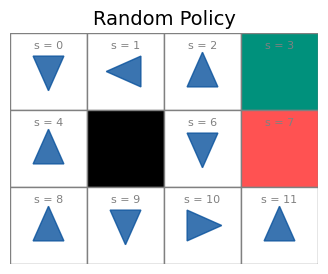

In [ ]:
# Visualize random policy
random_policy = np.random.randint(0, 4, size=world.num_states)
world.visualize_policy_and_values(policy=random_policy, values=None, title="Random Policy")

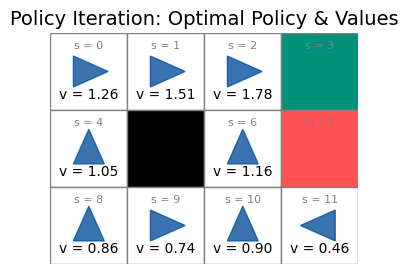

In [ ]:
# Visualize optimal policy and value
env.visualize_policy_and_values(policy=pi.policy, values=pi.V, title="Policy Iteration: Optimal Policy & Values")


line.png

## 🎲 Solving GridWorld with Monte Carlo Methods (Exploring Starts)

So far, we have solved the GridWorld problem using **Dynamic Programming methods** (Value Iteration and Policy Iteration) which require a full model of the environment (i.e., transition probabilities).

Now, we’ll tackle the same problem using **Monte Carlo (MC) methods**, which learn purely from sampled experience. Specifically, we’ll use the **Exploring Starts** version of Monte Carlo Control, which:

- Randomly starts episodes from different state-action pairs (to ensure sufficient exploration).
- Improves the policy using **every-visit Monte Carlo** returns.
- Gradually converges to an optimal policy with enough samples.

This is especially useful when the model is unknown or too large to enumerate.

---

### 🧠 Key Concepts

- **Episode**: A full sequence of states, actions, and rewards from start to termination.
- **Return \( G_t \)**: Cumulative discounted reward starting from time \( t \).
- **Q(s, a)**: Estimated return from state \( s \), taking action \( a \), and following policy \( \pi \) thereafter.
- **Policy Improvement**: Greedily updating the policy from Q-values.


In [ ]:
import random

class MonteCarloES:
    def __init__(self, env, gamma=0.9):
        self.env = env
        self.gamma = gamma
        self.Q = {}  # Q[s][a]
        self.returns = {}  # returns[s][a]
        self.policy = np.full(env.num_states, -1)
        self._init_q_and_policy()

    def _init_q_and_policy(self):
        for s in range(self.env.num_states):
            r, c = self.env.get_position(s)
            if self.env.map[r, c] in [1, 2, 3]:  # terminal or wall
                continue
            self.Q[s] = {}
            self.returns[s] = {}
            for a in range(self.env.num_actions):
                self.Q[s][a] = 0.0
                self.returns[s][a] = []
            self.policy[s] = random.randint(0, self.env.num_actions - 1)

    def generate_episode(self):
        # Randomly pick a starting state-action pair (Exploring Starts)
        while True:
            s = random.randint(0, self.env.num_states - 1)
            a = random.randint(0, self.env.num_actions - 1)
            r, c = self.env.get_position(s)
            if self.env.map[r, c] not in [1, 2, 3]:
                break

        episode = []
        current_state = s
        current_action = a

        while True:
            transitions = self.env.get_transitions(
                *self.env.get_position(current_state),
                current_action,
                slip=0.2
            )
            next_states, probs = zip(*transitions.items())
            next_state = np.random.choice(next_states, p=probs)
            reward = self.env.reward_function[next_state]
            episode.append((current_state, current_action, reward))

            r_, c_ = self.env.get_position(next_state)
            if self.env.map[r_, c_] in [1, 2]:  # terminal states
                break

            current_state = next_state
            current_action = self.policy[current_state] if self.policy[current_state] != -1 else random.randint(0, 3)

        return episode

    def run(self, episodes=5000):
        for _ in range(episodes):
            episode = self.generate_episode()
            G = 0
            visited = set()

            for t in reversed(range(len(episode))):
                s, a, r = episode[t]
                G = self.gamma * G + r

                if (s, a) not in visited:
                    self.returns[s][a].append(G)
                    self.Q[s][a] = np.mean(self.returns[s][a])
                    visited.add((s, a))

                    # Policy improvement: greedy
                    best_a = max(self.Q[s], key=self.Q[s].get)
                    self.policy[s] = best_a


🎯 **Monte Carlo Exploring Starts (MC-ES)**

We now run the Monte Carlo Exploring Starts method on our GridWorld environment.

This method:
- Starts each episode from a random (state, action) pair,
- Uses experience (returns) to estimate Q-values,
- Improves the policy greedily over time,
- Does not require any model of the environment (model-free).

Let’s run it below and visualize the learned policy.


In [ ]:
# Grid map: 0 = normal, 1 = goal, 2 = poison, 3 = wall
grid_map = [
    [0, 0, 0, 1],
    [0, 3, 0, 2],
    [0, 0, 0, 0]
]

# Build world and solve Value Iteration
world = GridWorld(grid_map)


# Initialize and train the MC agent
mc = MonteCarloES(world, gamma=0.9)
mc.run(episodes=100)

# Convert Q → V for visualization: V(s) = max_a Q(s,a)
mc_values = np.array([
    max(mc.Q[s].values()) if s in mc.Q and mc.Q[s] else 0.0
    for s in range(world.num_states)
])

# Visualize learned policy and values
world.visualize_policy_and_values(
    policy=mc.policy,
    values=mc_values,
    title="Monte Carlo Exploring Starts: Optimal Policy & Values"
)
